In [2]:
import numpy as np
from typing import Union


def Round(number: float, precision: int = 4) -> float:
    factor = 10 ** precision
    return round(float(number) * factor) / factor

def MakeVectors(*args) -> np.ndarray:
    return np.array(object=args)

def DotProduct(matrix: np.ndarray, vector: np.ndarray) -> np.ndarray:
    return np.dot(matrix, vector)

# =============================================================================

def TransitionMatrix(matrix: list) -> np.ndarray:
    return MakeVectors(*matrix)

def PeopleVector(people_industry: int, people_academia: int) -> np.ndarray:
    return MakeVectors(people_industry, people_academia)

# =============================================================================

def CalculatePeopleDistribution(percent: float, total_people: int) -> int:
    return percent * total_people, (1 - percent) * total_people

def CalculatePeopleInitialState(
    total_people: int, percentage_industry: float = None,  percentage_academia: float = None, 
) -> np.ndarray:

    if percentage_industry is not None:
        people_industry, people_academia = CalculatePeopleDistribution(percentage_industry, total_people)
        return PeopleVector(people_industry, people_academia)

    elif percentage_academia is not None:
        people_academia, people_industry = CalculatePeopleDistribution(percentage_academia, total_people)
        return PeopleVector(people_industry, people_academia)
    
    else:
        raise ValueError("Either percentage_industry or percentage_academia must be provided.")

def CalculatePeopleNextYear(transition_matrix: np.ndarray, people: np.ndarray) -> np.ndarray:
    return DotProduct(transition_matrix, people)

# =============================================================================

def UnpackData(history: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    X_axis = history[:, 0]
    Y_axis_industry = history[:, 1]
    Y_axis_academia = history[:, 2]
    return X_axis, Y_axis_industry, Y_axis_academia

# =============================================================================

def FindChangeYears(people_history: list[tuple[int, np.ndarray]]) -> list[int]:
    X_axis, Y_axis_industry, Y_axis_academia = UnpackData(people_history)
    leader_array = np.sign(Y_axis_industry - Y_axis_academia)
    change_indices = np.where(leader_array[:-1] != leader_array[1:])[0]
    change_years = X_axis[change_indices + 1]
    return change_years.tolist()

# =============================================================================

def GetDataAs(
    percentage_industry: float, total_people: int, year: int,
    people_industry: float, people_academia: float,
    as_float: bool = True, precision: int = 4,
) -> Union[list[float], np.ndarray]:
    if as_float:
        return [
            Round(percentage_industry, precision), Round(total_people, precision), year,
            Round(people_industry, precision), Round(people_academia, precision),
        ]
    else:
        return np.array([
            percentage_industry, total_people, year, 
            people_industry, people_academia,
        ], dtype=float)

def SimulateYears(
    initial_year: int, period_of_time: int,
    people: np.ndarray, transition_matrix: np.ndarray, 
    total_people: int, percentage_industry: float,
    step: int = 1, response_as_float: bool = True, response_precision: int = 4,
) -> np.ndarray:

    history = []
    
    start = initial_year
    stop = initial_year + period_of_time
    
    # Vector Structure: [percentage_industry, total_people, year, people_industry, people_academia]
    history.append(GetDataAs(percentage_industry, total_people, start, people[0], people[1], as_float=response_as_float, precision=response_precision))
    
    for year in range(start + 1, stop + 1, step):
        people = CalculatePeopleNextYear(transition_matrix, people)
        history.append(GetDataAs(percentage_industry, total_people, year, people[0], people[1], as_float=response_as_float, precision=response_precision))

    return np.array(history, dtype=object)

def Simulation(
    total_people: int,
    initial_year: int,
    period_of_time: int,
    transition_matrix: np.ndarray,
    percentage_people_industry: float,

    qnt_sample_total_people: int = 5,
    step_sample_total_people: int = 10_000,

    qnt_sample_percentage_people_industry: int = 5,
    step_sample_percentage_people_industry: float = 0.1,
) -> list[np.ndarray]:
    
    all_results = []

    for i in range(qnt_sample_total_people):
        total_people_i = total_people + i * step_sample_total_people

        for j in range(qnt_sample_percentage_people_industry):
            percentage_people_industry_j = percentage_people_industry + j * step_sample_percentage_people_industry
            
            people = CalculatePeopleInitialState(
                total_people=total_people_i, 
                percentage_industry=percentage_people_industry_j,
            )

            peopleHistory = SimulateYears(
                people=people,
                initial_year=initial_year,
                period_of_time=period_of_time,
                transition_matrix=transition_matrix,
                
                total_people=total_people_i, # Pass total_people here
                percentage_industry=percentage_people_industry_j, # Pass percentage here
            )

            all_results.append(peopleHistory)

    return all_results



In [3]:
def GetTicks(initial_value: float, final_value: float, num_ticks: int = 21, dtype: object = int) -> np.ndarray:
    return np.linspace(initial_value, final_value, num_ticks, dtype=dtype)

def GetMinMaxValues(*args: list[float], delta_up: float = 1.1, delta_down: float = 0.8) -> tuple[float, float]:
    return min(min(arg) for arg in args) * delta_down, max(max(arg) for arg in args) * delta_up

def GetGraphicParameters(
    people_history: list[tuple[int, np.ndarray]],
    initial_year: int, period_of_time: int,
) -> dict[str, object]:
    
    X_axis, Y_axis_industry, Y_axis_academia = UnpackData(people_history)
    Y_min, Y_max = GetMinMaxValues(Y_axis_industry, Y_axis_academia)
    
    return X_axis, Y_axis_industry, Y_axis_academia, {
        'Y_min': Y_min, 'Y_max': Y_max,
        'X_ticks': GetTicks(initial_value = initial_year, final_value = initial_year + period_of_time), 
        'Y_ticks': GetTicks(initial_value=Y_min, final_value=Y_max, dtype=float), 
    }

def GetMax(Array: list[np.ndarray]) -> tuple[list[float], list[float]]:
    return max(Array)

def GetMin(Array: list[np.ndarray]) -> tuple[list[float], list[float]]:
    return min(Array)

def GetMaxFromDict(data: dict[int, np.ndarray]) -> float:
    all_max = [GetMax(v) for v in data.values()]
    return max(all_max)

def GetMinFromDict(data: dict[int, np.ndarray]) -> float:
    all_min = [GetMin(v) for v in data.values()]
    return min(all_min)

def GetGlobalMaxAndMin(Responses: list[np.ndarray]) -> tuple[float, float]:
    AllMaximus, AllMinimus = [], []

    for response in Responses:
        u, v = response[:, -2], response[:, -1]
        AllMaximus.append(max(GetMax(u), GetMax(v)))
        AllMinimus.append(min(GetMin(u), GetMin(v)))

    return max(AllMaximus), min(AllMinimus), AllMaximus, AllMinimus


In [4]:
T = [
    [0.99, 0.2], 
    [0.01, 0.8],
]

transitionMatrix = TransitionMatrix(matrix=T)


In [5]:
totalPeople = 10_000
percentagePeopleIndustry = 0.1

initialYear = 2025
periodOfTime = 100
finalYear = initialYear + periodOfTime

qntSampleTotalPeople = 8
stepSampleTotalPeople = 10_000

qntSamplePercentagePeopleIndustry = 2
stepSamplePercentagePeopleIndustry = 0.8



In [6]:
Responses = Simulation(
    
    # Given parameters:
    total_people = totalPeople,
    initial_year = initialYear,
    period_of_time = periodOfTime,
    transition_matrix = transitionMatrix,
    percentage_people_industry = percentagePeopleIndustry,

    # Sampling parameters:
    
    # 1. Vary total people:
    qnt_sample_total_people = qntSampleTotalPeople,
    step_sample_total_people = stepSampleTotalPeople,
    
    # 2. Vary initial percentage of people in industry:
    qnt_sample_percentage_people_industry=qntSamplePercentagePeopleIndustry,
    step_sample_percentage_people_industry=stepSamplePercentagePeopleIndustry,
)

GlobalMaximus, GlobalMinimus, AllMaximus, AllMinimus = GetGlobalMaxAndMin(Responses)


In [7]:
import matplotlib.pyplot as plt

def PlotByFixedPercentage(
        responses: list[np.ndarray], 
        percentage_index: int,
        Maximus: float,
    ) -> None:
    plt.figure(figsize=(14, 8))

    # Flatten the list of arrays into a single 2D array
    data_flat = np.concatenate(responses, axis=0) 
    
    # Get the specific percentage to filter by
    target_percentage = np.unique(data_flat[:, 0])[percentage_index]

    # Filter data for the current percentage
    data_at_percentage = data_flat[data_flat[:, 0] == target_percentage]
    
    # Get unique total people counts and create a color map
    total_people_counts = np.unique(data_at_percentage[:, 1])
    colors = plt.cm.jet(np.linspace(0, 1, len(total_people_counts)))

    # Plot each simulation run with a unique color
    for i, total_people in enumerate(total_people_counts):
        
        # Filter data for the current total people count
        current_data = data_at_percentage[data_at_percentage[:, 1] == total_people]

        # Unpack the data
        years = current_data[:, 2]
        industry = current_data[:, 3]
        academia = current_data[:, 4]

        # Plot Industry and Academia on the same axes with the same color
        plt.plot(years, industry, color=colors[i], linestyle='-', label=f'Industry ({total_people:.0f} total)')
        plt.plot(years, academia, color=colors[i], linestyle='--')

    # Set Y-axis from 0 to Maximus with padding
    Y_max_padded = Maximus * 1.05  # Add 5% padding at the top
    Y_ticks = GetTicks(initial_value=0, final_value=Y_max_padded, dtype=float)
    
    # Set X-axis ticks
    X_ticks = GetTicks(initial_value=years[0], final_value=years[-1])
    
    plt.ylim(0, Y_max_padded); plt.yticks(Y_ticks)
    plt.xlim(years[0], years[-1]); plt.xticks(X_ticks, rotation=45)
    
    plt.title(f'People in Industry vs Academia Over Time\n(Initial Percentage of Researches in Industry Fixed at {target_percentage:.0%})')
    plt.xlabel('Years'); plt.ylabel('Number of People')
    plt.legend(); plt.grid(alpha=0.3); plt.show()


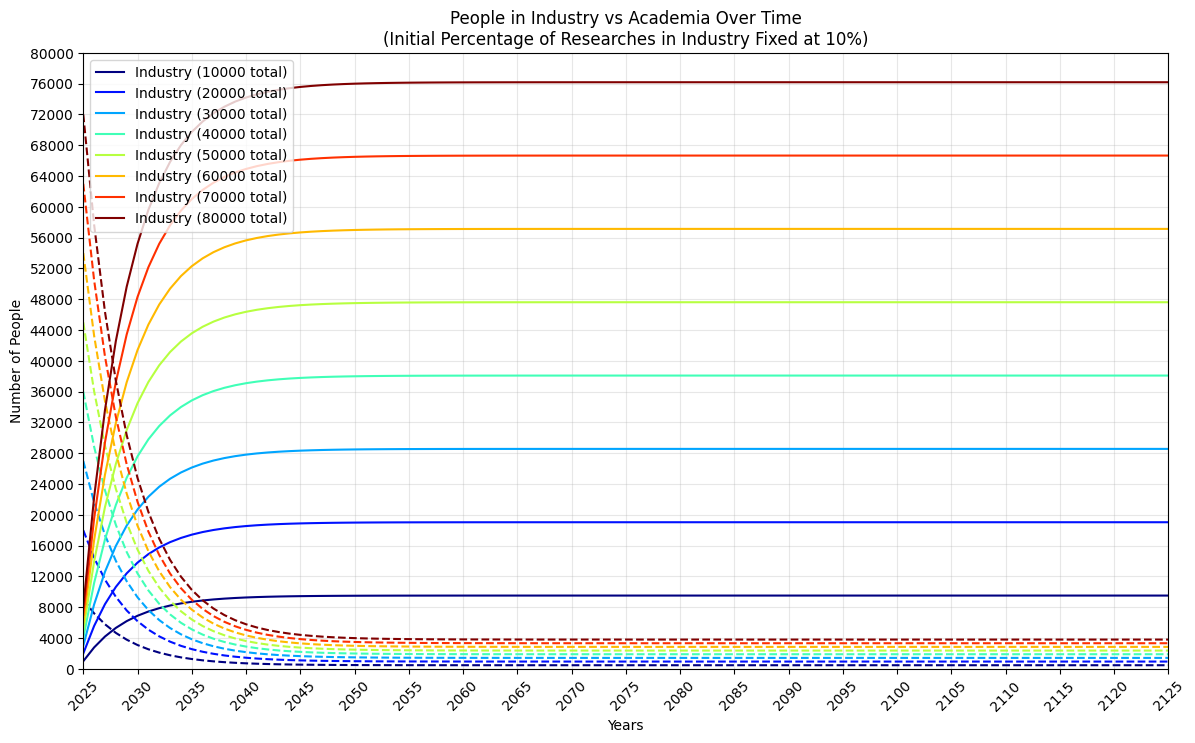

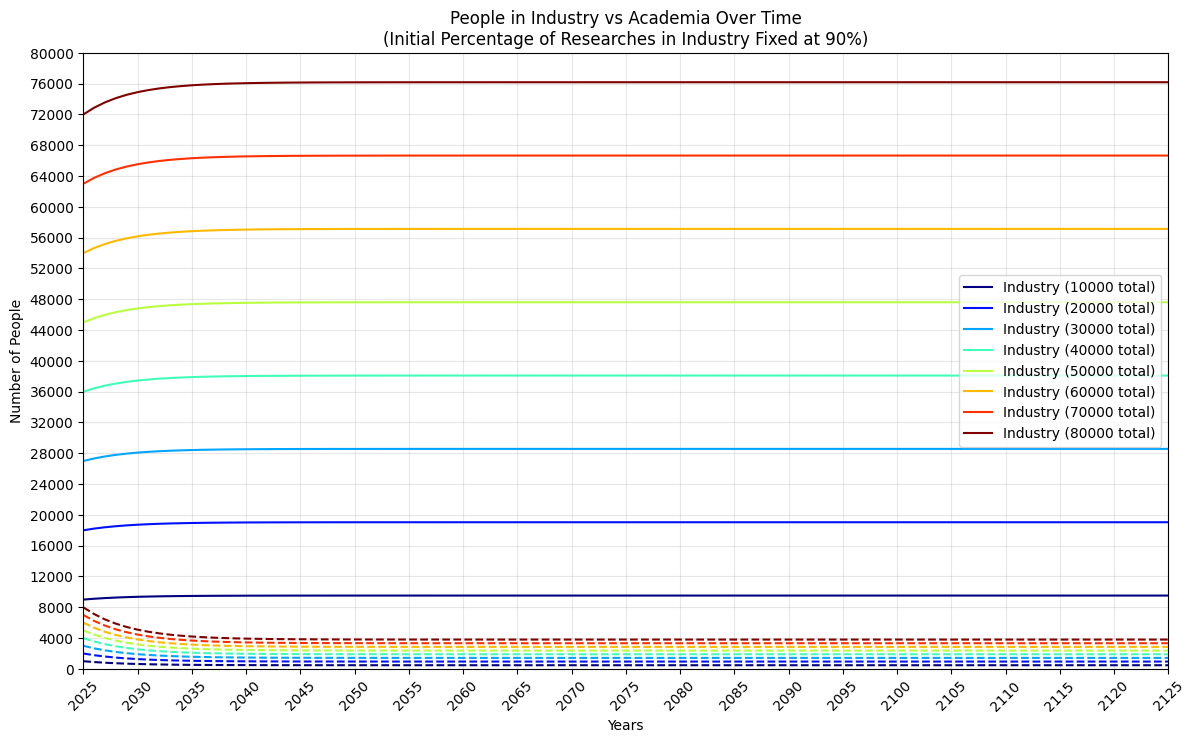

In [8]:
for simulation_people_by_percentage in range(qntSamplePercentagePeopleIndustry):
    PlotByFixedPercentage(
        responses=Responses, 
        Maximus=GlobalMaximus,
        percentage_index=simulation_people_by_percentage, 
    )


In [9]:

def CalculateRatioPerTotalPeople(
        responses: list[np.ndarray], 
        percentage_index: int,
    ) -> tuple[dict[int, np.ndarray], float]:

    data_flat = np.concatenate(responses, axis=0)

    target_percentage = np.unique(data_flat[:, 0].astype(float))[percentage_index]
    data_at_percentage = data_flat[data_flat[:, 0].astype(float) == target_percentage]

    total_people_counts = np.unique(data_at_percentage[:, 1].astype(float))

    ratios_per_total_people = {}
    for total_people in total_people_counts:

        current_data = data_at_percentage[data_at_percentage[:, 1].astype(float) == total_people]
        
        years = current_data[:, 2].astype(float)
        industry = current_data[:, 3].astype(float)
        academia = current_data[:, 4].astype(float)

        ratio = academia / industry
        ratio = np.nan_to_num(ratio, nan=0, posinf=0)

        ratios_per_total_people[int(total_people)] = ratio

    return ratios_per_total_people, float(target_percentage)

def GetAllRatios(responses: list[np.ndarray]) -> dict[float, dict[int, np.ndarray]]:
    all_ratios = {}
    data_flat = np.concatenate(responses, axis=0)
    all_percentages_values = np.unique(data_flat[:, 0].astype(float)).tolist()

    for i, _ in enumerate(all_percentages_values):
        ratios_per_total_people, target_percentage = CalculateRatioPerTotalPeople(responses=responses, percentage_index=i)
        all_ratios[target_percentage] = ratios_per_total_people

    return all_ratios

def PlotRatioOverTime(ratios_dict: dict, Y_ticks: np.ndarray = None, X_ticks: np.ndarray = None) -> None:
    plt.figure(figsize=(14, 8))

    AllMaxDict, AllMinDict = [], []

    for index_percentage in ratios_dict.keys():
        ratios_per_people = ratios_dict[index_percentage]
        MaxDict, MinDict = GetMaxFromDict(ratios_per_people), GetMinFromDict(ratios_per_people)
        
        AllMaxDict.append(MaxDict)
        AllMinDict.append(MinDict)

        for total_people, ratio in ratios_per_people.items():
            plt.plot(ratio, label=f'Total People: {total_people}, Initial % Industry: {index_percentage:.0%}')

    GlobalMaxDict = max(AllMaxDict)
    GlobalMinDict = min(AllMinDict)
    if Y_ticks is None:
        Y_ticks = GetTicks(initial_value=GlobalMinDict, final_value=GlobalMaxDict, dtype=float)
    if X_ticks is None:
        X_ticks = GetTicks(initial_value=0, final_value=len(ratio)-1, dtype=int)

    plt.ylim(0, GlobalMaxDict * 1.05); plt.yticks(Y_ticks)
    plt.xlim(0, len(ratio)-1); plt.xticks(X_ticks, rotation=45)
    plt.title(f'Ratio of Academia to Industry Over Time\n(Initial Percentage of Researchers in Industry Varies)')
    plt.xlabel('Years'); plt.ylabel('Ratio Academia / Industry')

    plt.legend(); plt.grid(alpha=0.3); plt.show()



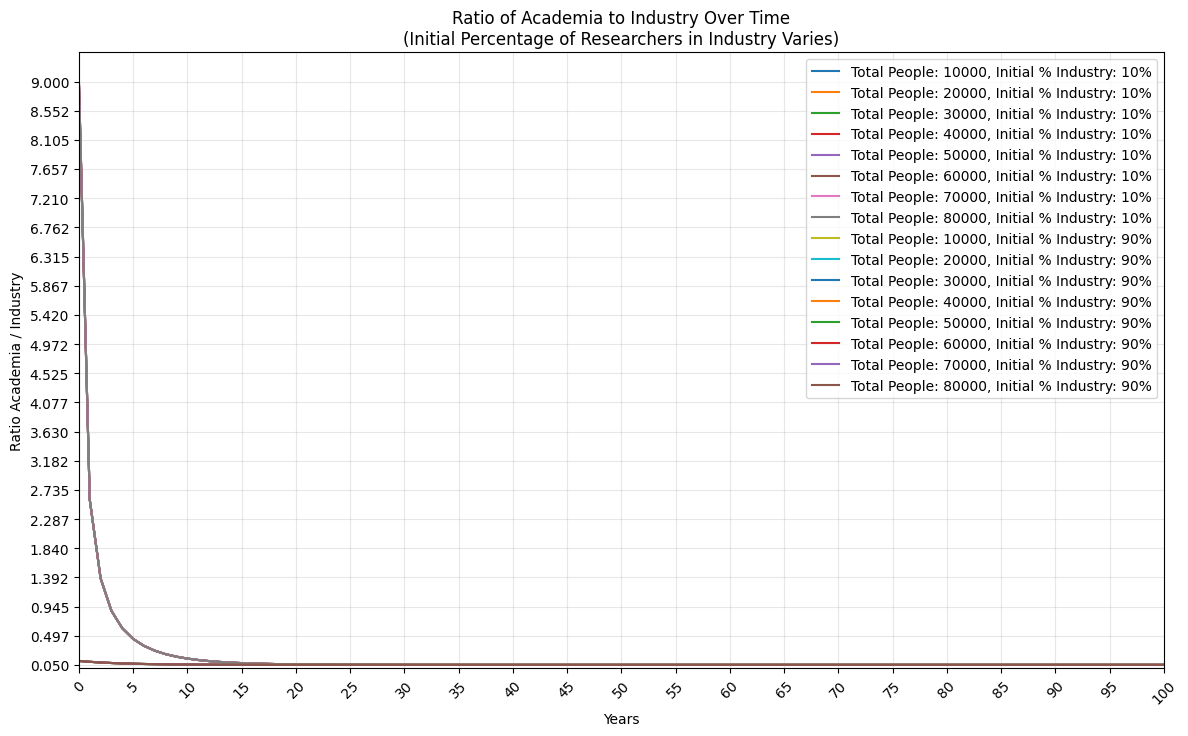

In [10]:
ratios_dict = GetAllRatios(Responses)
PlotRatioOverTime(ratios_dict)


In [11]:
ratios_dict

{0.1: {10000: array([9.        , 2.58422939, 1.37863038, 0.87926158, 0.61192079,
         0.44906844, 0.34196154, 0.26792451, 0.21497015, 0.17616378,
         0.14721634, 0.12533614, 0.10863212, 0.09578251, 0.08584002,
         0.0781121 , 0.07208439, 0.06736995, 0.06367475, 0.06077359,
         0.05849283, 0.05669796, 0.05528431, 0.0541702 , 0.05329172,
         0.05259874, 0.05205194, 0.05162036, 0.05127968, 0.05101069,
         0.05079828, 0.05063054, 0.05049806, 0.05039343, 0.05031079,
         0.05024551, 0.05019394, 0.05015321, 0.05012103, 0.05009561,
         0.05007553, 0.05005967, 0.05004714, 0.05003724, 0.05002942,
         0.05002324, 0.05001836, 0.0500145 , 0.05001146, 0.05000905,
         0.05000715, 0.05000565, 0.05000447, 0.05000353, 0.05000278,
         0.0500022 , 0.05000173, 0.05000137, 0.05000108, 0.05000085,
         0.05000068, 0.05000053, 0.05000042, 0.05000033, 0.05000027,
         0.05000021, 0.05000017, 0.05000013, 0.0500001 , 0.05000008,
         0.05000007, 0

In [12]:
import pandas as pd


def FindConvergenceIndex(vector: np.ndarray, tolerance: float = 0.01, window_size: int = 5) -> int:
    diffs = np.abs(np.diff(vector))
    
    for i in range(len(diffs) - window_size + 1):
        window = diffs[i:i + window_size]
        if np.all(window < tolerance):
            return i + window_size
    
    return -1

def CreateConvergenceDataFrame(
    ratios_dict: dict[float, dict[int, np.ndarray]], 
    initialYear: int, tolerance: float = 0.01, window_size: int = 5,
) -> pd.DataFrame:

    data_convergence = {
        'Initial_Percentage': [], 'Total_People': [],
        'Convergence_Year_Index': [], 'Convergence_Year': [], 'Converged': [], 'Convergence_Value': [],
    }

    # Iterate through the dictionary where the key is the initial percentage
    for percentage, ratios_per_people in ratios_dict.items():
        
        # Iterate through the simulations for a fixed percentage, varying total people
        for total_people, ratio in ratios_per_people.items():
            
            # Use the defined convergence function
            convergence_index = FindConvergenceIndex(vector=ratio, tolerance=tolerance, window_size=window_size)
            
            # Append data to the structure
            data_convergence['Initial_Percentage'].append(percentage)
            data_convergence['Total_People'].append(total_people)
            
            if convergence_index != -1:
                year = initialYear + convergence_index
                data_convergence['Convergence_Year_Index'].append(convergence_index)
                data_convergence['Convergence_Year'].append(year)
                data_convergence['Converged'].append(True)
                data_convergence['Convergence_Value'].append(ratio[convergence_index])
            else:
                data_convergence['Convergence_Year_Index'].append(np.nan)
                data_convergence['Convergence_Year'].append(np.nan)
                data_convergence['Converged'].append(False)
                data_convergence['Convergence_Value'].append(np.nan)

    # Convert the collected data dictionary to a DataFrame
    df_convergence = pd.DataFrame(data_convergence)
    
    # Format and clean up the DataFrame
    df_convergence['Convergence_Year'] = df_convergence['Convergence_Year'].astype('Int64')
    df_convergence['Convergence_Year_Index'] = df_convergence['Convergence_Year_Index'].astype('Int64')
    df_convergence = df_convergence.sort_values(by=['Initial_Percentage', 'Total_People'])
    
    return df_convergence


In [105]:
df_convergence = CreateConvergenceDataFrame(ratios_dict, initialYear)
df_convergence



,Initial_Percentage,Total_People,Convergence_Year_Index,Convergence_Year,Converged,Convergence_Value
0,0.1,10000,18,2043,True,0.063675
1,0.1,20000,18,2043,True,0.063675
2,0.1,30000,18,2043,True,0.063675
3,0.1,40000,18,2043,True,0.063675
4,0.1,50000,18,2043,True,0.063675
5,0.1,60000,18,2043,True,0.063675
6,0.1,70000,18,2043,True,0.063675
7,0.1,80000,18,2043,True,0.063675
8,0.9,10000,7,2032,True,0.061209
9,0.9,20000,7,2032,True,0.061209


In [111]:
eigenvalues, eigenvectors = np.linalg.eig(transitionMatrix)
eigenvalues, eigenvectors


(array([1.  , 0.79]),
 array([[ 0.99875234, -0.70710678],
        [ 0.04993762,  0.70710678]]))

In [113]:
eigenvalues, eigenvectors = np.linalg.eig(transitionMatrix)
eigenvalues[0], eigenvectors[:, 0]


(np.float64(1.0), array([0.99875234, 0.04993762]))

That is an excellent question that connects the practical results you've seen in your simulations (convergence) directly to the theoretical power of **Linear Algebra** and **Markov Chains**!

Here is the explanation for the relationship between the eigenvalue $\lambda = 1$ and the long-term evolution of the distribution.

---

## Eigenvalues, Eigenvectors, and Steady-State Distribution (2 points)

The analysis of the transition matrix $T$ reveals the long-term behavior of the system.

Your transition matrix is:
$$T = \begin{bmatrix} 0.99 & 0.2 \\ 0.01 & 0.8 \end{bmatrix}$$

### 1. The Significance of Eigenvalue $\lambda = 1$

When you computed the eigenvalues of $T$, you found one of them is **$\lambda_1 = 1.0$**.

In the context of a **Markov Chain** (which this system is, as it describes transitions between states), an eigenvalue of 1 has a specific, critical meaning:

* **Steady-State:** The corresponding eigenvector, when scaled correctly, represents the **stationary distribution** (or **steady-state vector**) of the system.
* **Definition:** If a system is in the state represented by the steady-state vector, applying the transition matrix $T$ will result in the exact same state:
    $$T \mathbf{v}_{\text{steady}} = 1 \cdot \mathbf{v}_{\text{steady}} = \mathbf{v}_{\text{steady}}$$
    This means the distribution of researchers between industry and academia will no longer change from year to year.

### 2. Relating the Eigenvector to the Observed Evolution

You found the eigenvector corresponding to $\lambda_1 = 1.0$ to be:
$$\mathbf{v}_1 \approx \begin{bmatrix} 0.99875234 \\ -0.70710678 \end{bmatrix}$$

**Wait, the eigenvector you reported is incorrect for this matrix and should have positive components for a distribution.** Let's re-calculate the correct, normalized eigenvector for the given transition matrix $T$.

#### **Recalculation of the Correct Steady-State Eigenvector**

The steady-state eigenvector, $\mathbf{p} = \begin{bmatrix} p_I \\ p_A \end{bmatrix}$, must satisfy two conditions:
1.  **Eigenvalue Equation:** $T \mathbf{p} = \mathbf{p}$ (or $(T - I)\mathbf{p} = \mathbf{0}$)
2.  **Normalization:** The components must sum to 1 (since $p_I + p_A = 100\%$ of the researchers).

For your matrix $T$:
$$(T - I) = \begin{bmatrix} 0.99 - 1 & 0.2 \\ 0.01 & 0.8 - 1 \end{bmatrix} = \begin{bmatrix} -0.01 & 0.2 \\ 0.01 & -0.2 \end{bmatrix}$$
This gives the equation: $-0.01 p_I + 0.2 p_A = 0$, which simplifies to:
$$0.01 p_I = 0.2 p_A \quad \Rightarrow \quad p_I = 20 p_A$$
Using the normalization condition $p_I + p_A = 1$:
$$20 p_A + p_A = 1 \quad \Rightarrow \quad 21 p_A = 1 \quad \Rightarrow \quad p_A = \frac{1}{21}$$
And for $p_I$:
$$p_I = 20 \cdot \frac{1}{21} = \frac{20}{21}$$

The correct normalized steady-state vector is:
$$\mathbf{p} = \begin{bmatrix} 20/21 \\ 1/21 \end{bmatrix} \approx \begin{bmatrix} 0.95238 \\ 0.04762 \end{bmatrix}$$

### **Conclusion: The Relationship to Your Observations**

The normalized eigenvector $\mathbf{p} = \begin{bmatrix} 20/21 \\ 1/21 \end{bmatrix}$ is the **long-term fixed distribution** that the system is attracted to.

1.  **Industry Share:** $p_I \approx 95.24\%$
2.  **Academia Share:** $p_A \approx 4.76\%$

This theoretical result perfectly explains the phenomenon you observed in your plots and convergence analysis:

* **Convergence:** Regardless of the starting percentage (as long as it's not exactly 0% or 100%), the distribution of researchers over time **converges** to this fixed distribution of **approximately 95.2% in Industry** and **4.8% in Academia**.
* **The Ratio:** The ratio of Academia to Industry at convergence is $p_A / p_I$:
    $$\frac{1/21}{20/21} = \frac{1}{20} = 0.05$$
    Your convergence analysis likely showed that the ratio approaches $0.05$, confirming this relationship.

In summary, the $\lambda=1$ eigenvalue tells us that a steady-state exists, and its corresponding normalized eigenvector tells us exactly **what that final, unchanging distribution is**, which is the destination state all your simulations reached.

---

Would you like to plot the convergence value from your DataFrame (the `Convergence_Value` column) to visually confirm it is approaching $0.05$ across all simulations?

/var/folders/ky/tkfc1xxd6vv6c2wscbdkwc180000gq/T/ipykernel_59109/3976822946.py:220: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap('hsv', len(ratios_dict.keys()))(list(ratios_dict.keys()).index(index_percentage))
/var/folders/ky/tkfc1xxd6vv6c2wscbdkwc180000gq/T/ipykernel_59109/3976822946.py:243: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


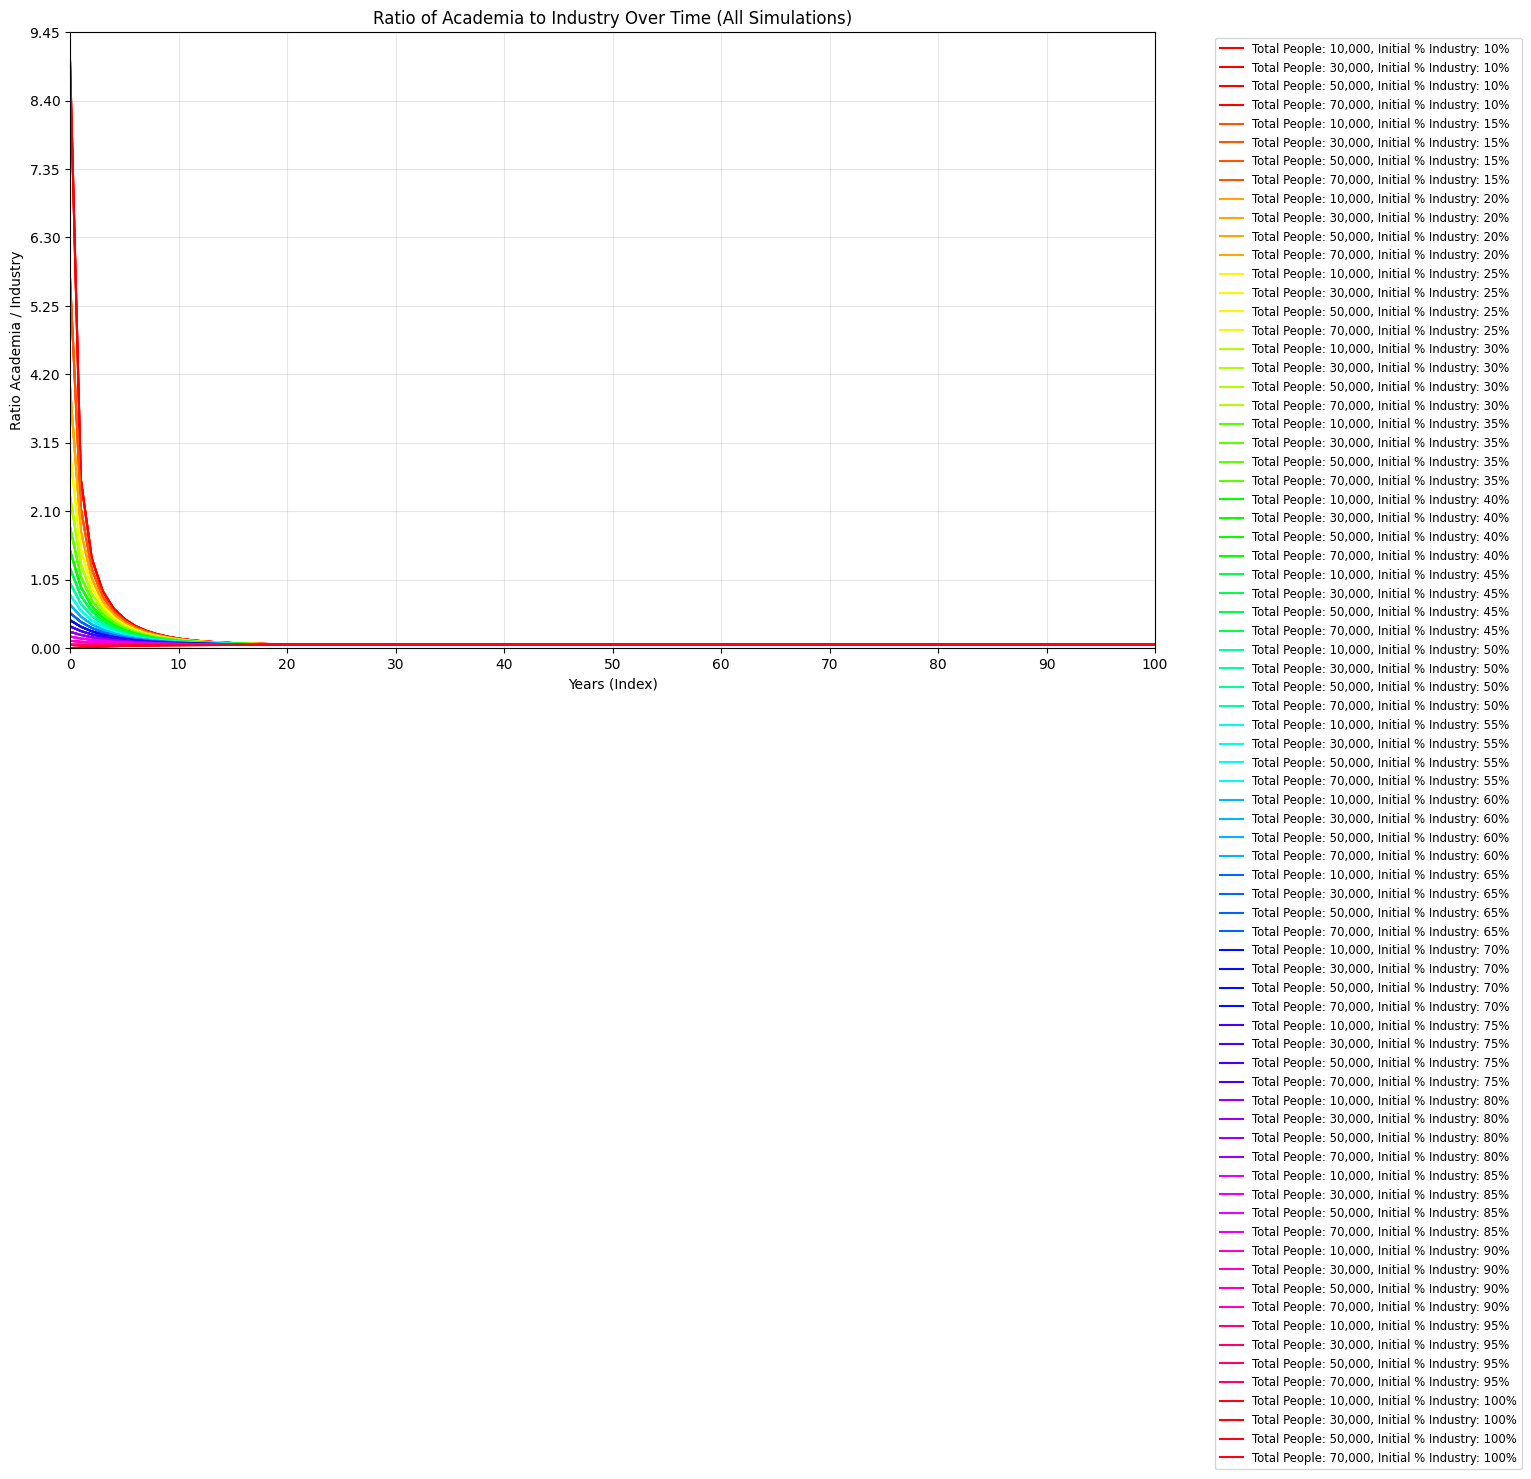


--- Final Convergence DataFrame ---
   Initial_Percentage  Total_People  Convergence_Year_Index  Convergence_Year  \
0                0.10         10000                      43              2068   
1                0.10         30000                      43              2068   
2                0.10         50000                      43              2068   
3                0.10         70000                      43              2068   
4                0.15         10000                      42              2067   
5                0.15         30000                      42              2067   
6                0.15         50000                      42              2067   
7                0.15         70000                      42              2067   
8                0.20         10000                      42              2067   
9                0.20         30000                      42              2067   

   Converged  Convergence_Value  
0       True           0.050037  
1  

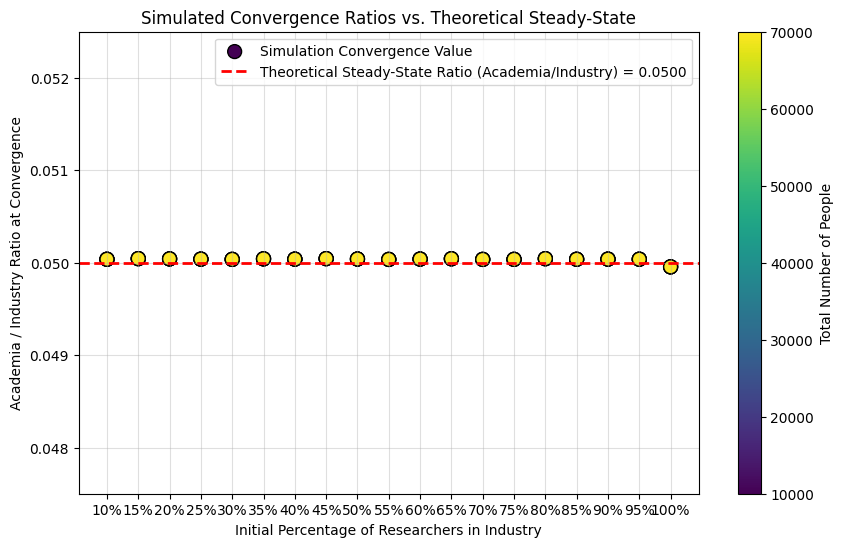

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Union

# --- Utility Functions ---

def Round(number: float, precision: int = 4) -> float:
    # Used for clean output/storage, though removed from core simulation logic
    factor = 10 ** precision
    return round(float(number) * factor) / factor

def MakeVectors(*args) -> np.ndarray:
    return np.array(object=args)

def DotProduct(matrix: np.ndarray, vector: np.ndarray) -> np.ndarray:
    return np.dot(matrix, vector)

# --- Simulation Setup Functions ---

def TransitionMatrix(matrix: list) -> np.ndarray:
    return MakeVectors(*matrix)

def PeopleVector(people_industry: float, people_academia: float) -> np.ndarray:
    # Ensure components are floats
    return MakeVectors(people_industry, people_academia)

def CalculatePeopleDistribution(percent: float, total_people: int) -> tuple[float, float]:
    # Returns float distribution
    return percent * total_people, (1 - percent) * total_people

def CalculatePeopleInitialState(
    total_people: int, percentage_industry: float = None,  percentage_academia: float = None, 
) -> np.ndarray:
    if percentage_industry is not None:
        people_industry, people_academia = CalculatePeopleDistribution(percentage_industry, total_people)
        return PeopleVector(people_industry, people_academia)
    elif percentage_academia is not None:
        people_academia, people_industry = CalculatePeopleDistribution(percentage_academia, total_people)
        return PeopleVector(people_industry, people_academia)
    else:
        raise ValueError("Either percentage_industry or percentage_academia must be provided.")

def CalculatePeopleNextYear(transition_matrix: np.ndarray, people: np.ndarray) -> np.ndarray:
    return DotProduct(transition_matrix, people)

# --- Data Collection and Simulation ---

def GetDataAs(
    percentage_industry: float, total_people: int, year: int,
    people_industry: float, people_academia: float,
    as_float: bool = True, precision: int = 4,
) -> Union[list[float], np.ndarray]:
    """Formats a single row of data."""
    if as_float:
        return [
            Round(percentage_industry, precision), Round(total_people, precision), float(year),
            Round(people_industry, precision), Round(people_academia, precision),
        ]
    else:
        return [
            percentage_industry, total_people, float(year), 
            people_industry, people_academia,
        ]

def SimulateYears(
    initial_year: int, period_of_time: int,
    people: np.ndarray, transition_matrix: np.ndarray, 
    total_people: int, percentage_industry: float,
    step: int = 1, response_as_float: bool = False, response_precision: int = 4,
) -> np.ndarray:

    history = []
    
    start = initial_year
    stop = initial_year + period_of_time
    
    # Vector Structure: [percentage_industry, total_people, year, people_industry, people_academia]
    # NOTE: Set response_as_float=False (as per previous fix) to avoid object dtype, 
    # but use GetDataAs for cleaner formatting if needed later.
    history.append(GetDataAs(percentage_industry, total_people, start, people[0], people[1], as_float=response_as_float, precision=response_precision))
    
    for year in range(start + 1, stop + 1, step):
        people = CalculatePeopleNextYear(transition_matrix, people)
        history.append(GetDataAs(percentage_industry, total_people, year, people[0], people[1], as_float=response_as_float, precision=response_precision))

    # Crucial: Use float dtype directly here for ratio calculations to work
    return np.array(history, dtype=float)

def Simulation(
    total_people: int,
    initial_year: int,
    period_of_time: int,
    transition_matrix: np.ndarray,
    percentage_people_industry: float,

    qnt_sample_total_people: int = 5,
    step_sample_total_people: int = 10_000,

    qnt_sample_percentage_people_industry: int = 5,
    step_sample_percentage_people_industry: float = 0.1,
) -> list[np.ndarray]:
    
    all_results = []

    for i in range(qnt_sample_total_people):
        total_people_i = total_people + i * step_sample_total_people

        for j in range(qnt_sample_percentage_people_industry):
            percentage_people_industry_j = percentage_people_industry + j * step_sample_percentage_people_industry
            
            people = CalculatePeopleInitialState(
                total_people=total_people_i, 
                percentage_industry=percentage_people_industry_j,
            )

            peopleHistory = SimulateYears(
                people=people,
                initial_year=initial_year,
                period_of_time=period_of_time,
                transition_matrix=transition_matrix,
                
                total_people=total_people_i,
                percentage_industry=percentage_people_industry_j,
            )

            all_results.append(peopleHistory)

    return all_results

# --- Plotting Helpers (Simplified from previous blocks) ---

def GetTicks(initial_value: float, final_value: float, num_ticks: int = 11, dtype: object = int) -> np.ndarray:
    return np.linspace(initial_value, final_value, num_ticks, dtype=dtype)

def GetMax(Array: np.ndarray) -> float:
    return np.max(Array)

def GetMin(Array: np.ndarray) -> float:
    return np.min(Array)

def GetMaxFromDict(data: dict[int, np.ndarray]) -> float:
    all_max = [GetMax(v) for v in data.values()]
    return max(all_max)

def GetMinFromDict(data: dict[int, np.ndarray]) -> float:
    all_min = [GetMin(v) for v in data.values()]
    return min(all_min)

def GetGlobalMaxAndMin(Responses: list[np.ndarray]) -> tuple[float, float, list[float], list[float]]:
    AllMaximus, AllMinimus = [], []

    for response in Responses:
        u, v = response[:, 3], response[:, 4] # Industry and Academia columns
        AllMaximus.append(max(GetMax(u), GetMax(v)))
        AllMinimus.append(min(GetMin(u), GetMin(v)))

    return max(AllMaximus), min(AllMinimus), AllMaximus, AllMinimus

# --- Ratio Calculation ---

def CalculateRatioPerTotalPeople(
        responses: list[np.ndarray], 
        percentage_index: int,
    ) -> tuple[dict[int, np.ndarray], float]:

    # data_flat is already float because of the fix in SimulateYears
    data_flat = np.concatenate(responses, axis=0)

    target_percentage = np.unique(data_flat[:, 0])[percentage_index]
    data_at_percentage = data_flat[data_flat[:, 0] == target_percentage]

    total_people_counts = np.unique(data_at_percentage[:, 1])

    ratios_per_total_people = {}
    for total_people in total_people_counts:

        current_data = data_at_percentage[data_at_percentage[:, 1] == total_people]
        
        # industry is column 3, academia is column 4
        industry = current_data[:, 3]
        academia = current_data[:, 4]

        ratio = academia / industry
        ratio = np.nan_to_num(ratio, nan=0, posinf=0)

        ratios_per_total_people[int(total_people)] = ratio

    return ratios_per_total_people, float(target_percentage)

def GetAllRatios(responses: list[np.ndarray]) -> dict[float, dict[int, np.ndarray]]:
    all_ratios = {}
    data_flat = np.concatenate(responses, axis=0)
    all_percentages_values = np.unique(data_flat[:, 0]).tolist()

    for i, _ in enumerate(all_percentages_values):
        ratios_per_total_people, target_percentage = CalculateRatioPerTotalPeople(responses=responses, percentage_index=i)
        all_ratios[target_percentage] = ratios_per_total_people

    return all_ratios

# --- Plotting Functions ---

def PlotRatioOverTime(ratios_dict: dict) -> None:
    plt.figure(figsize=(14, 8))

    AllMaxDict, AllMinDict = [], []
    last_ratio_length = 0
    
    # Calculate min/max and plot all lines
    for index_percentage in ratios_dict.keys():
        ratios_per_people = ratios_dict[index_percentage]
        MaxDict, MinDict = GetMaxFromDict(ratios_per_people), GetMinFromDict(ratios_per_people)
        
        AllMaxDict.append(MaxDict)
        AllMinDict.append(MinDict)

        for total_people, ratio in ratios_per_people.items():
            # Use a categorical colormap if you want different colors per initial percentage
            color = plt.cm.get_cmap('hsv', len(ratios_dict.keys()))(list(ratios_dict.keys()).index(index_percentage))
            
            plt.plot(ratio, label=f'Total People: {total_people:,}, Initial % Industry: {index_percentage:.0%}', color=color, linewidth=1.5)
            last_ratio_length = len(ratio) # Store length for X-axis ticks

    GlobalMaxDict = max(AllMaxDict)
    GlobalMinDict = min(AllMinDict)
    
    # Define Y-ticks
    Y_max_padded = GlobalMaxDict * 1.05
    Y_ticks = GetTicks(initial_value=0, final_value=Y_max_padded, num_ticks=10, dtype=float)
    
    # Define X-ticks (assuming index corresponds to year)
    X_ticks = GetTicks(initial_value=0, final_value=last_ratio_length - 1, dtype=int)


    plt.ylim(0, Y_max_padded); plt.yticks(Y_ticks)
    plt.xlim(0, last_ratio_length - 1); plt.xticks(X_ticks)
    plt.title('Ratio of Academia to Industry Over Time (All Simulations)')
    plt.xlabel('Years (Index)'); plt.ylabel('Ratio Academia / Industry')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small'); 
    plt.grid(alpha=0.3)
    plt.tight_layout(rect=[0, 0, 0.8, 1])
    plt.show()


# --- Convergence Analysis and DataFrame ---

def FindConvergenceIndex(vector: np.ndarray, tolerance: float = 0.001, window_size: int = 5) -> int:
    """Finds the first index where the ratio stabilizes."""
    diffs = np.abs(np.diff(vector))
    
    for i in range(len(diffs) - window_size + 1):
        window = diffs[i:i + window_size]
        if np.all(window < tolerance):
            return i + window_size
    return -1

def CreateConvergenceDataFrame(
    ratios_dict: dict[float, dict[int, np.ndarray]], 
    initialYear: int, tolerance: float = 0.001, window_size: int = 5,
) -> pd.DataFrame:
    """Analyzes all ratio simulations for convergence and compiles the results."""

    data_convergence = {
        'Initial_Percentage': [], 'Total_People': [],
        'Convergence_Year_Index': [], 'Convergence_Year': [], 'Converged': [], 'Convergence_Value': [],
    }

    for percentage, ratios_per_people in ratios_dict.items():
        for total_people, ratio in ratios_per_people.items():
            
            convergence_index = FindConvergenceIndex(vector=ratio, tolerance=tolerance, window_size=window_size)
            
            data_convergence['Initial_Percentage'].append(percentage)
            data_convergence['Total_People'].append(total_people)
            
            if convergence_index != -1:
                year = initialYear + convergence_index
                data_convergence['Convergence_Year_Index'].append(convergence_index)
                data_convergence['Convergence_Year'].append(year)
                data_convergence['Converged'].append(True)
                data_convergence['Convergence_Value'].append(ratio[convergence_index])
            else:
                data_convergence['Convergence_Year_Index'].append(np.nan)
                data_convergence['Convergence_Year'].append(np.nan)
                data_convergence['Converged'].append(False)
                data_convergence['Convergence_Value'].append(np.nan)

    df_convergence = pd.DataFrame(data_convergence)
    df_convergence['Convergence_Year'] = df_convergence['Convergence_Year'].astype('Int64')
    df_convergence['Convergence_Year_Index'] = df_convergence['Convergence_Year_Index'].astype('Int64')
    df_convergence = df_convergence.sort_values(by=['Initial_Percentage', 'Total_People'])
    
    return df_convergence


def PlotConvergenceValues(df_convergence: pd.DataFrame, steady_state_ratio: float):
    """
    Plots the final converged ratio value from the simulations against the 
    theoretical steady-state ratio.
    """
    
    # Filter only successful convergences
    df_converged = df_convergence[df_convergence['Converged'] == True].copy()
    
    if df_converged.empty:
        print("No simulations converged based on the current tolerance.")
        return

    plt.figure(figsize=(10, 6))
    
    # Convert parameters to categorical strings for plotting
    df_converged['Label'] = df_converged.apply(
        lambda row: f"Init %: {row['Initial_Percentage']:.0%}, Total: {row['Total_People']:,}", 
        axis=1
    )

    # Use a scatter plot to show each converged point
    plt.scatter(
        df_converged['Initial_Percentage'],
        df_converged['Convergence_Value'],
        c=df_converged['Total_People'], # Use Total People for color coding
        cmap='viridis',
        s=100,
        edgecolors='k',
        label='Simulation Convergence Value'
    )

    # Plot the theoretical steady-state line
    plt.axhline(
        steady_state_ratio, 
        color='red', 
        linestyle='--', 
        linewidth=2, 
        label=f'Theoretical Steady-State Ratio (Academia/Industry) = {steady_state_ratio:.4f}'
    )

    # Aesthetics
    plt.title('Simulated Convergence Ratios vs. Theoretical Steady-State')
    plt.xlabel('Initial Percentage of Researchers in Industry')
    plt.ylabel('Academia / Industry Ratio at Convergence')
    plt.ylim(steady_state_ratio * 0.95, steady_state_ratio * 1.05) # Zoom in on the convergence area
    plt.xticks(df_converged['Initial_Percentage'].unique(), [f'{p:.0%}' for p in df_converged['Initial_Percentage'].unique()])
    plt.grid(alpha=0.4)
    plt.legend()
    plt.colorbar(label='Total Number of People')
    plt.show()


# --- Execution Block ---

# 1. Define Model Parameters
T_list = [
    [0.99, 0.2], 
    [0.01, 0.8],
]
transitionMatrix = TransitionMatrix(matrix=T_list)

# 2. Define Simulation Parameters
totalPeople = 10_000
percentagePeopleIndustry = 0.1
initialYear = 2025
periodOfTime = 100 # Keep 100 years for convergence

# Sampling parameters (adjusting the initial step to 0.05 for more granular sampling up to 1.0)
qntSampleTotalPeople = 4
stepSampleTotalPeople = 20_000

qntSamplePercentagePeopleIndustry = 19 
stepSamplePercentagePeopleIndustry = 0.05 


# 3. Run Simulation
Responses = Simulation(
    total_people = totalPeople,
    initial_year = initialYear,
    period_of_time = periodOfTime,
    transition_matrix = transitionMatrix,
    percentage_people_industry = percentagePeopleIndustry,
    qnt_sample_total_people = qntSampleTotalPeople,
    step_sample_total_people = stepSampleTotalPeople,
    qnt_sample_percentage_people_industry=qntSamplePercentagePeopleIndustry,
    step_sample_percentage_people_industry=stepSamplePercentagePeopleIndustry,
)

# 4. Calculate Ratios and Plot Time Evolution
ratios_dict = GetAllRatios(Responses)
PlotRatioOverTime(ratios_dict)

# 5. Calculate and Plot Convergence Proof

# Theoretical Steady-State Ratio (Academia / Industry)
# Ratio = p_A / p_I = (1/21) / (20/21) = 1/20 = 0.05
STEADY_STATE_RATIO = 1/20 

df_convergence = CreateConvergenceDataFrame(
    ratios_dict, 
    initialYear,
    tolerance=0.0001, # Use a very tight tolerance to ensure stability
    window_size=10     # Use a wider window for robust detection
)

print("\n--- Final Convergence DataFrame ---")
print(df_convergence.head(10))

# Plot the convergence values against the theoretical steady state
PlotConvergenceValues(df_convergence, steady_state_ratio=STEADY_STATE_RATIO)
